In [1]:
import os
import glob
import gzip
from collections import defaultdict
import pysam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn import metrics
from statsmodels.stats.multitest import multipletests

sns.set_style("darkgrid")
sns.set_context("notebook")
sns.set_palette("deep")


# SNV Benchmark

## Comparative analysis

### Sensitivity, Precision, and F1


In [2]:
sample_ids = pd.read_csv("sample_ids.csv")


def read_summary(file_path):
    try:
        with open(file_path, "r") as f:
            lines = f.readlines()

        none_line = next(
            (line for line in lines if line.strip().startswith("None")), None
        )

        if none_line:
            values = none_line.split()
            metrics = {
                "True-pos-baseline": int(values[1]),
                "True-pos-call": int(values[2]),
                "False-pos": int(values[3]),
                "False-neg": int(values[4]),
                "Precision": float(values[5]),
                "Sensitivity": float(values[6]),
                "F-measure": float(values[7]),
            }
            return metrics
        else:
            print(f"No 'None' threshold line found in {file_path}")
            return {}
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return {}
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return {}


def calculate_rtg_statistics(df):
    return df.groupby("complexity").agg(
        {
            "Precision": ["mean", "std", "median", "min", "max"],
            "Sensitivity": ["mean", "std", "median", "min", "max"],
            "F-measure": ["mean", "std", "median", "min", "max"],
        }
    )


snv_ont_hc_metrics = []
snv_ont_lc_metrics = []
snv_illumina_hc_metrics = []
snv_illumina_lc_metrics = []

complexities = ["hc", "lc"]
technologies = ["ont", "illumina"]

for _, row in sample_ids.iterrows():
    ont_id = row["ont_id"]
    lp_id = row["lp_id"]

    for tech in technologies:
        for complexity in complexities:
            sample_id = ont_id if tech == "ont" else lp_id
            summary_file = (
                f"output/snv/rtg_vcfeval/{complexity}/{sample_id}.snv/summary.txt"
            )
            summary = read_summary(summary_file)

            if summary:
                metrics_entry = {
                    "sample_id": sample_id,
                    "complexity": complexity,
                    **summary,
                }

                if tech == "ont":
                    if complexity == "hc":
                        snv_ont_hc_metrics.append(metrics_entry)
                    else:
                        snv_ont_lc_metrics.append(metrics_entry)
                elif tech == "illumina":
                    if complexity == "hc":
                        snv_illumina_hc_metrics.append(metrics_entry)
                    else:
                        snv_illumina_lc_metrics.append(metrics_entry)
            else:
                print(f"Skipping empty summary for {sample_id}, {tech}, {complexity}")


snv_ont_metrics_df = pd.DataFrame(snv_ont_hc_metrics + snv_ont_lc_metrics)
snv_illumina_metrics_df = pd.DataFrame(
    snv_illumina_hc_metrics + snv_illumina_lc_metrics
)

snv_ont_stats = calculate_rtg_statistics(snv_ont_metrics_df)
snv_illumina_stats = calculate_rtg_statistics(snv_illumina_metrics_df)

snv_ont_stats


Precision                                   Sensitivity            \
                mean       std  median     min     max        mean       std   
complexity                                                                     
hc          0.959100  0.003764  0.9599  0.9550  0.9624    0.965467  0.004704   
lc          0.789733  0.004941  0.7890  0.7852  0.7950    0.753633  0.005595   

                                   F-measure                                    
            median     min     max      mean       std  median     min     max  
complexity                                                                      
hc          0.9666  0.9603  0.9695  0.962300  0.004288  0.9633  0.9576  0.9660  
lc          0.7514  0.7495  0.7600  0.771233  0.005270  0.7697  0.7669  0.7771

In [3]:
snv_illumina_stats


Precision                                   Sensitivity            \
                mean       std  median     min     max        mean       std   
complexity                                                                     
hc            0.9655  0.000721  0.9653  0.9649  0.9663    0.972567  0.000586   
lc            0.8017  0.001572  0.8014  0.8003  0.8034    0.743833  0.002098   

                                   F-measure                                    
            median     min     max      mean       std  median     min     max  
complexity                                                                      
hc          0.9728  0.9719  0.9730  0.969067  0.000153  0.9691  0.9689  0.9692  
lc          0.7431  0.7422  0.7462  0.771667  0.001401  0.7721  0.7701  0.7728

In [4]:
def perform_ttest(ont_data, illumina_data, metric):
    ont_values = ont_data[metric]
    illumina_values = illumina_data[metric]
    t_stat, p_value = stats.ttest_ind(ont_values, illumina_values)
    return t_stat, p_value


metrics_to_test = ["Precision", "Sensitivity", "F-measure"]

for df in [snv_ont_stats, snv_illumina_stats]:
    for metric in metrics_to_test:
        df[(metric, "t_statistic")] = None
        df[(metric, "p_value")] = None
        df[(metric, "adjusted_p_value")] = None

all_p_values = []

for complexity in complexities:
    ont_data = snv_ont_metrics_df[snv_ont_metrics_df["complexity"] == complexity]
    illumina_data = snv_illumina_metrics_df[
        snv_illumina_metrics_df["complexity"] == complexity
    ]

    for metric in metrics_to_test:
        t_stat, p_value = perform_ttest(ont_data, illumina_data, metric)

        snv_ont_stats.loc[complexity, (metric, "t_statistic")] = t_stat
        snv_ont_stats.loc[complexity, (metric, "p_value")] = p_value

        snv_illumina_stats.loc[complexity, (metric, "t_statistic")] = t_stat
        snv_illumina_stats.loc[complexity, (metric, "p_value")] = p_value

        all_p_values.append(p_value)

# Perform FDR correction
_, adjusted_p_values, _, _ = multipletests(all_p_values, method="fdr_bh")

adjusted_p_value_index = 0
for complexity in complexities:
    for metric in metrics_to_test:
        adjusted_p_value = adjusted_p_values[adjusted_p_value_index]
        snv_ont_stats.loc[complexity, (metric, "adjusted_p_value")] = adjusted_p_value
        snv_illumina_stats.loc[complexity, (metric, "adjusted_p_value")] = (
            adjusted_p_value
        )
        adjusted_p_value_index += 1

print("ONT SNV Stats:")
snv_ont_stats


ONT SNV Stats:


Precision                                   Sensitivity            \
                mean       std  median     min     max        mean       std   
complexity                                                                     
hc          0.959100  0.003764  0.9599  0.9550  0.9624    0.965467  0.004704   
lc          0.789733  0.004941  0.7890  0.7852  0.7950    0.753633  0.005595   

                                    ... F-measure   Precision            \
            median     min     max  ...       max t_statistic   p_value   
complexity                          ...                                   
hc          0.9666  0.9603  0.9695  ...    0.9660   -2.892209  0.044464   
lc          0.7514  0.7495  0.7600  ...    0.7771   -3.997535  0.016163   

                            Sensitivity                             \
           adjusted_p_value t_statistic   p_value adjusted_p_value   
complexity                                                           
hc                 0.072478   -2.594476  0.060398         0.072478   
lc                 0.072478    2.840613  0.046839         0.072478   

             F-measure                             
           t_statistic   p_value adjusted_p_value  
complexity                                         
hc           -2.731299  0.052373         0.072478  
lc           -0.137637  0.897177         0.897177  

[2 rows x 24 columns]

In [5]:
print("\nIllumina SNV Stats:")
snv_illumina_stats



Illumina SNV Stats:


Precision                                   Sensitivity            \
                mean       std  median     min     max        mean       std   
complexity                                                                     
hc            0.9655  0.000721  0.9653  0.9649  0.9663    0.972567  0.000586   
lc            0.8017  0.001572  0.8014  0.8003  0.8034    0.743833  0.002098   

                                    ... F-measure   Precision            \
            median     min     max  ...       max t_statistic   p_value   
complexity                          ...                                   
hc          0.9728  0.9719  0.9730  ...    0.9692   -2.892209  0.044464   
lc          0.7431  0.7422  0.7462  ...    0.7728   -3.997535  0.016163   

                            Sensitivity                             \
           adjusted_p_value t_statistic   p_value adjusted_p_value   
complexity                                                           
hc                 0.072478   -2.594476  0.060398         0.072478   
lc                 0.072478    2.840613  0.046839         0.072478   

             F-measure                             
           t_statistic   p_value adjusted_p_value  
complexity                                         
hc           -2.731299  0.052373         0.072478  
lc           -0.137637  0.897177         0.897177  

[2 rows x 24 columns]

### Error Analysis


[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/A153_06.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/LP6008462-DNA_D03.snv/tp.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: output/snv/rtg_vcfeval/hc/LP6008463-DNA_E01.snv/tp.vcf.gz.tbi


<Figure size 2000x1000 with 0 Axes>

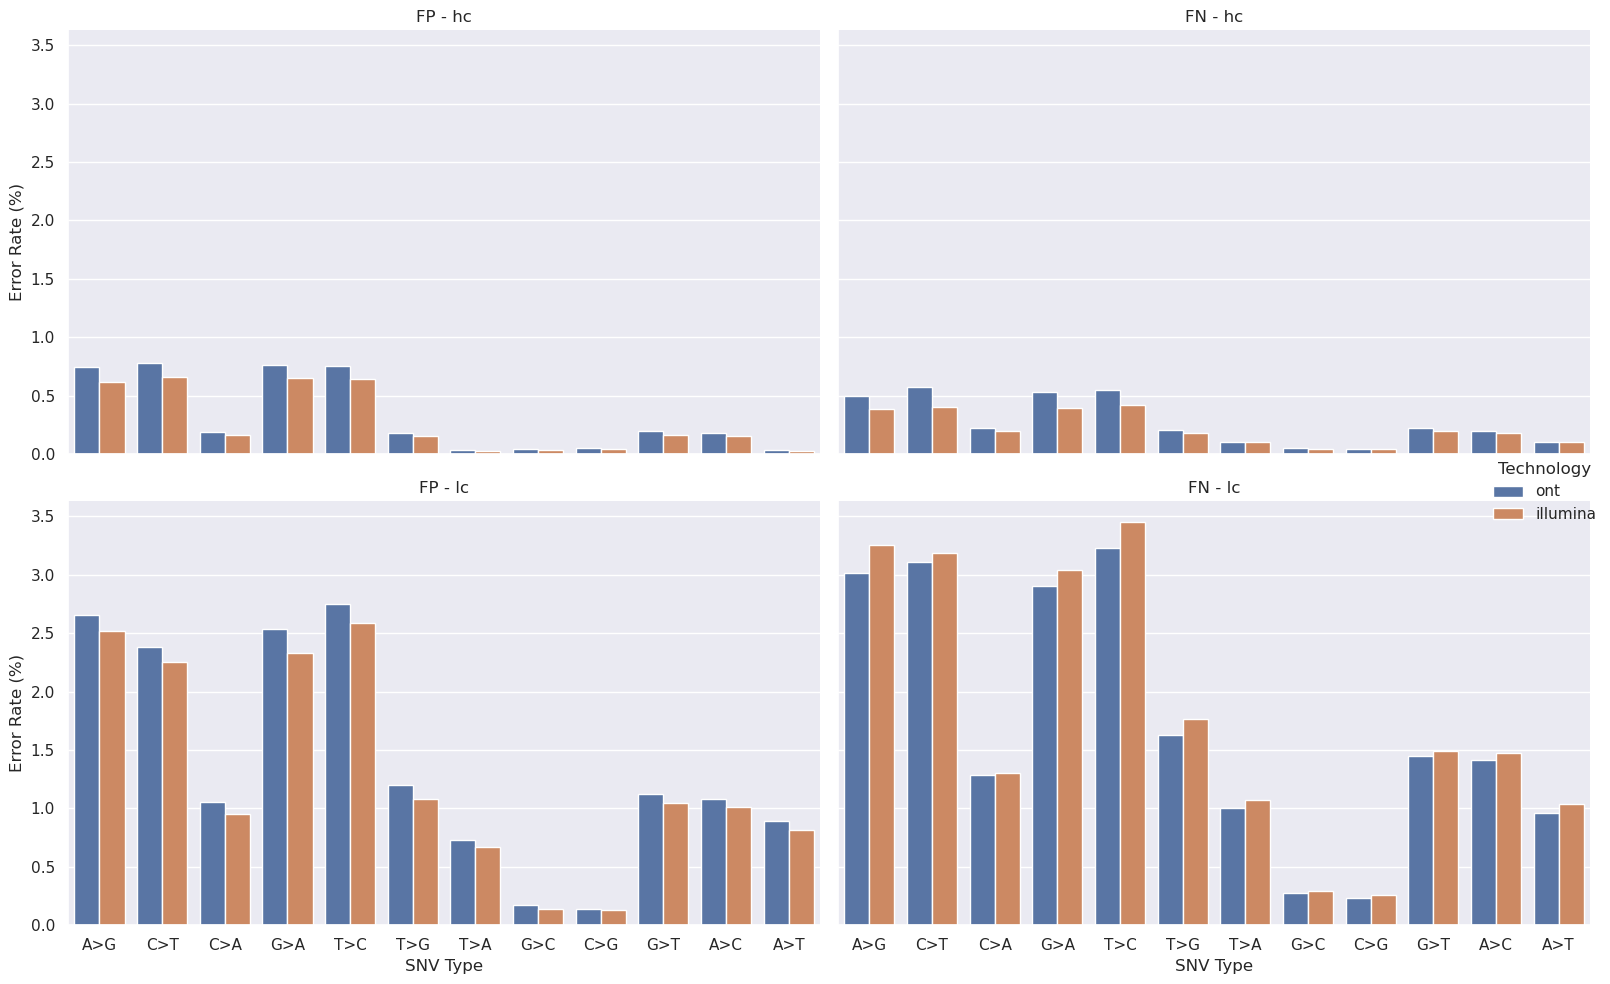

In [6]:
def analyze_snv_errors(technology, complexity, sample_ids):
    error_types = defaultdict(lambda: defaultdict(int))
    total_variants = 0
    fn_count = 0

    for _, row in sample_ids.iterrows():
        sample_id = row["ont_id"] if technology == "ont" else row["lp_id"]
        base_path = f"output/snv/rtg_vcfeval/{complexity}/{sample_id}.snv"

        fp_file = os.path.join(base_path, "fp.vcf.gz")
        fn_file = os.path.join(base_path, "fn.vcf.gz")
        tp_file = os.path.join(base_path, "tp.vcf.gz")

        with pysam.VariantFile(tp_file) as vcf:
            total_variants += sum(1 for _ in vcf)

        with pysam.VariantFile(fp_file) as vcf:
            for record in vcf:
                ref = record.ref
                alt = record.alts[0]
                error_types["FP"][f"{ref}>{alt}"] += 1
                total_variants += 1

        with pysam.VariantFile(fn_file) as vcf:
            for record in vcf:
                ref = record.ref
                alt = record.alts[0]
                error_types["FN"][f"{ref}>{alt}"] += 1
                fn_count += 1

    total_variants += fn_count

    return error_types, total_variants


snv_error_data = {}
snv_total_variants_data = {}

for tech in technologies:
    for comp in complexities:
        snv_error_data[f"{tech}_{comp}"], snv_total_variants_data[f"{tech}_{comp}"] = (
            analyze_snv_errors(tech, comp, sample_ids)
        )

snv_plot_data = []
for tech_comp, error_data in snv_error_data.items():
    tech, comp = tech_comp.split("_")
    total_variants = snv_total_variants_data[tech_comp]
    for error_type, snv_types in error_data.items():
        for snv_type, count in snv_types.items():
            error_rate = (count / total_variants) * 100
            snv_plot_data.append(
                {
                    "Technology": tech,
                    "Complexity": comp,
                    "Error Type": error_type,
                    "SNV Type": snv_type,
                    "Error Rate (%)": error_rate,
                }
            )

snv_plot_df = pd.DataFrame(snv_plot_data)

plt.figure(figsize=(20, 10))
g = sns.catplot(
    data=snv_plot_df,
    x="SNV Type",
    y="Error Rate (%)",
    hue="Technology",
    col="Error Type",
    row="Complexity",
    kind="bar",
    height=5,
    aspect=1.5,
    legend=True,
)
g.set_axis_labels("SNV Type", "Error Rate (%)")
g.set_titles("{col_name} - {row_name}")
g.fig.subplots_adjust(right=0.85)
handles, labels = g.axes[0, 0].get_legend_handles_labels()
plt.tight_layout()
plt.show()
plt.close()


In [7]:
for tech_comp, total in snv_total_variants_data.items():
    tech, comp = tech_comp.split("_")
    print(f"{tech.upper()} - {comp.upper()}: Total SNV variants = {total}")


ONT - HC: Total SNV variants = 2041098
ONT - LC: Total SNV variants = 104983
ILLUMINA - HC: Total SNV variants = 2028491
ILLUMINA - LC: Total SNV variants = 103527


In [8]:
def perform_statistical_test(
    ont_data, illumina_data, ont_total, illumina_total, error_type, snv_type
):
    ont_error = ont_data[error_type].get(snv_type, 0)
    illumina_error = illumina_data[error_type].get(snv_type, 0)

    contingency_table = [
        [ont_error, ont_total - ont_error],
        [illumina_error, illumina_total - illumina_error],
    ]

    if any(any(cell < 5 for cell in row) for row in contingency_table):
        _, p_value = stats.fisher_exact(contingency_table)
    else:
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    return p_value


results = []

for comp in complexities:
    ont_data = snv_error_data[f"ont_{comp}"]
    illumina_data = snv_error_data[f"illumina_{comp}"]
    ont_total = snv_total_variants_data[f"ont_{comp}"]
    illumina_total = snv_total_variants_data[f"illumina_{comp}"]

    for error_type in ["FP", "FN"]:
        snv_types = set(ont_data[error_type].keys()) | set(
            illumina_data[error_type].keys()
        )

        for snv_type in snv_types:
            p_value = perform_statistical_test(
                ont_data, illumina_data, ont_total, illumina_total, error_type, snv_type
            )
            ont_rate = ont_data[error_type].get(snv_type, 0) / ont_total * 100
            illumina_rate = (
                illumina_data[error_type].get(snv_type, 0) / illumina_total * 100
            )

            results.append(
                {
                    "Complexity": comp,
                    "Error Type": error_type,
                    "SNV Type": snv_type,
                    "ONT Rate (%)": ont_rate,
                    "Illumina Rate (%)": illumina_rate,
                    "p-value": p_value,
                }
            )

results_df = pd.DataFrame(results)

# Perform FDR correction
_, p_values_corrected, _, _ = multipletests(results_df["p-value"], method="fdr_bh")
results_df["Adjusted p-value"] = p_values_corrected

results_df = results_df.sort_values(["Complexity", "Error Type", "SNV Type"])

results_df["ONT Rate (%)"] = results_df["ONT Rate (%)"].map("{:.4f}".format)
results_df["Illumina Rate (%)"] = results_df["Illumina Rate (%)"].map("{:.4f}".format)
results_df["p-value"] = results_df["p-value"].map("{:.4e}".format)
results_df["Adjusted p-value"] = results_df["Adjusted p-value"].map("{:.4e}".format)

results_df["Significance"] = results_df["Adjusted p-value"].apply(
    lambda x: (
        "***"
        if float(x) < 0.001
        else ("**" if float(x) < 0.01 else ("*" if float(x) < 0.05 else ""))
    )
)

print("Statistical test results for SNVs:")
print(results_df.to_string(index=False))


Statistical test results for SNVs:
Complexity Error Type SNV Type ONT Rate (%) Illumina Rate (%)     p-value Adjusted p-value Significance
        hc         FN      A>C       0.1968            0.1845  4.6709e-03       9.7481e-03           **
        hc         FN      A>G       0.4995            0.3876  1.2625e-64       1.5150e-63          ***
        hc         FN      A>T       0.1047            0.1043  9.0440e-01       9.0440e-01             
        hc         FN      C>A       0.2206            0.1975  3.4576e-07       1.1064e-06          ***
        hc         FN      C>G       0.0479            0.0399  1.3384e-04       4.0153e-04          ***
        hc         FN      C>T       0.5739            0.4021 2.4808e-136      1.1908e-134          ***
        hc         FN      G>A       0.5329            0.3929  4.4540e-96       1.0690e-94          ***
        hc         FN      G>C       0.0502            0.0436  2.3201e-03       5.7380e-03           **
        hc         FN      G>

# Indel Benchmark

## Comparative analysis

### Sensitivity, Precision, and F1


In [9]:
indel_metrics = []

complexities = ["hc", "lc"]

for _, row in sample_ids.iterrows():
    ont_id = row["ont_id"]

    for complexity in complexities:
        summary_file = (
            f"output/indel/rtg_vcfeval/{complexity}/{ont_id}.indel/summary.txt"
        )
        summary = read_summary(summary_file)

        if summary:
            metrics_entry = {
                "sample_id": ont_id,
                "complexity": complexity,
                **summary,
            }
            indel_metrics.append(metrics_entry)
        else:
            print(f"Skipping empty summary for {ont_id}, {complexity}")

indel_metrics_df = pd.DataFrame(indel_metrics)
indel_stats = calculate_rtg_statistics(indel_metrics_df)

print("Indel Stats:")
indel_stats


Indel Stats:


Precision                                   Sensitivity            \
                mean       std  median     min     max        mean       std   
complexity                                                                     
hc          0.838367  0.028206  0.8269  0.8177  0.8705    0.921100  0.011903   
lc          0.540867  0.030669  0.5316  0.5159  0.5751    0.431367  0.031949   

                                   F-measure                                    
            median     min     max      mean       std  median     min     max  
complexity                                                                      
hc          0.9198  0.9099  0.9336  0.877700  0.020657  0.8709  0.8613  0.9009  
lc          0.4202  0.4065  0.4674  0.479933  0.031835  0.4694  0.4547  0.5157

### Error Analysis


In [10]:
def analyze_indel_errors(complexity, sample_ids):
    error_types = defaultdict(lambda: defaultdict(int))
    total_variants = 0
    fn_count = 0

    for _, row in sample_ids.iterrows():
        sample_id = row["ont_id"]
        base_path = f"output/indel/rtg_vcfeval/{complexity}/{sample_id}.indel"

        fp_file = os.path.join(base_path, "fp.vcf.gz")
        fn_file = os.path.join(base_path, "fn.vcf.gz")
        tp_file = os.path.join(base_path, "tp.vcf.gz")

        with pysam.VariantFile(tp_file) as vcf:
            total_variants += sum(1 for _ in vcf)

        with pysam.VariantFile(fp_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                error_types["FP"][f"{indel_type}_{indel_length}"] += 1
                total_variants += 1

        with pysam.VariantFile(fn_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                error_types["FN"][f"{indel_type}_{indel_length}"] += 1
                fn_count += 1

    total_variants += fn_count

    return error_types, total_variants


indel_error_data = {}
indel_total_variants_data = {}

for comp in complexities:
    indel_error_data[comp], indel_total_variants_data[comp] = analyze_indel_errors(
        comp, sample_ids
    )

indel_plot_data = []
for comp, error_data in indel_error_data.items():
    total_variants = indel_total_variants_data[comp]
    for error_type, indel_types in error_data.items():
        for indel_type, count in indel_types.items():
            error_rate = (count / total_variants) * 100
            indel_plot_data.append(
                {
                    "Complexity": comp,
                    "Error Type": error_type,
                    "Indel Type": indel_type,
                    "Error Rate (%)": error_rate,
                }
            )

indel_plot_df = pd.DataFrame(indel_plot_data)

indel_plot_df


,Complexity,Error Type,Indel Type,Error Rate (%)
0,hc,FP,deletion_1,4.054718
1,hc,FP,deletion_4,0.734278
2,hc,FP,insertion_4,0.540005
3,hc,FP,insertion_1,3.538127
4,hc,FP,deletion_3,0.746721
...,...,...,...,...
393,lc,FN,insertion_29,0.003996
394,lc,FN,insertion_39,0.002651
395,lc,FN,insertion_46,0.001460
396,lc,FN,insertion_49,0.001037


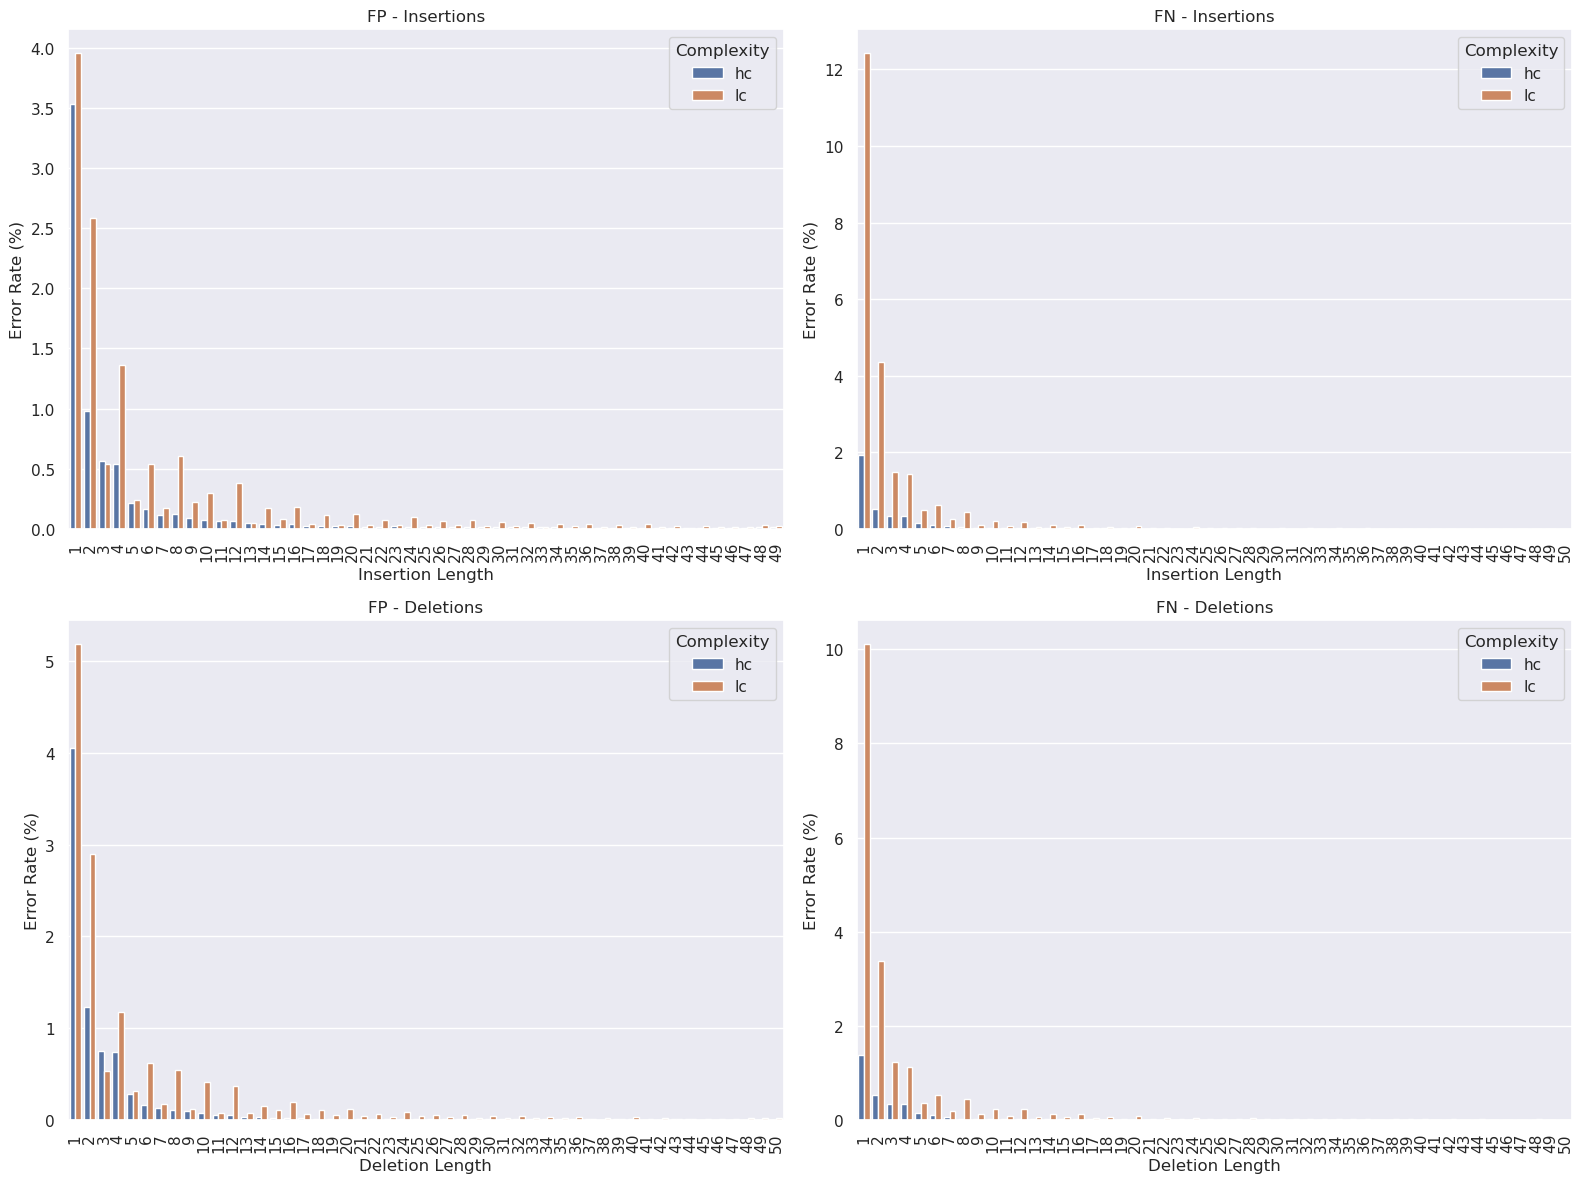

In [11]:
def preprocess_indel_data(df):
    df["Indel Length"] = df["Indel Type"].str.split("_").str[-1].astype(int)
    df["Indel Category"] = df["Indel Type"].str.split("_").str[0]
    df = df.sort_values(["Indel Category", "Indel Length", "Complexity"])
    return df


indel_plot_df = preprocess_indel_data(indel_plot_df)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, error_type in enumerate(["FP", "FN"]):
    for j, indel_category in enumerate(["insertion", "deletion"]):
        data = indel_plot_df[
            (indel_plot_df["Error Type"] == error_type)
            & (indel_plot_df["Indel Category"] == indel_category)
        ]

        sns.barplot(
            data=data,
            x="Indel Length",
            y="Error Rate (%)",
            hue="Complexity",
            hue_order=["hc", "lc"],
            ax=axes[j, i],
        )

        axes[j, i].set_title(f"{error_type} - {indel_category.capitalize()}s")
        axes[j, i].set_xlabel(f"{indel_category.capitalize()} Length")
        axes[j, i].set_ylabel("Error Rate (%)")

        unique_lengths = sorted(data["Indel Length"].unique())
        axes[j, i].set_xticks(range(len(unique_lengths)))
        axes[j, i].set_xticklabels(unique_lengths)

        axes[j, i].tick_params(axis="x", rotation=90)
        axes[j, i].legend(title="Complexity")

plt.tight_layout()
plt.show()
plt.close()


In [12]:
for comp, total in indel_total_variants_data.items():
    print(f"{comp.upper()}: Total indel variants = {total}")


HC: Total indel variants = 747401
LC: Total indel variants = 2602596


In [13]:
def perform_statistical_test(
    hc_data, lc_data, hc_total, lc_total, error_type, indel_type
):
    hc_error = hc_data[error_type].get(indel_type, 0)
    lc_error = lc_data[error_type].get(indel_type, 0)

    contingency_table = [
        [hc_error, hc_total - hc_error],
        [lc_error, lc_total - lc_error],
    ]

    if any(any(cell < 5 for cell in row) for row in contingency_table):
        _, p_value = stats.fisher_exact(contingency_table)
    else:
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    return p_value


hc_data = indel_error_data["hc"]
lc_data = indel_error_data["lc"]
hc_total = indel_total_variants_data["hc"]
lc_total = indel_total_variants_data["lc"]

results = []

for error_type in ["FP", "FN"]:
    indel_types = set(hc_data[error_type].keys()) | set(lc_data[error_type].keys())

    for indel_type in indel_types:
        p_value = perform_statistical_test(
            hc_data, lc_data, hc_total, lc_total, error_type, indel_type
        )
        hc_rate = hc_data[error_type].get(indel_type, 0) / hc_total * 100
        lc_rate = lc_data[error_type].get(indel_type, 0) / lc_total * 100

        results.append(
            {
                "Error Type": error_type,
                "Indel Type": indel_type,
                "HC Rate (%)": hc_rate,
                "LC Rate (%)": lc_rate,
                "p-value": p_value,
            }
        )

results_df = pd.DataFrame(results)

_, p_values_corrected, _, _ = multipletests(results_df["p-value"], method="fdr_bh")
results_df["Adjusted p-value"] = p_values_corrected

results_df = results_df.sort_values(["Error Type", "Indel Type"])

results_df["HC Rate (%)"] = results_df["HC Rate (%)"].map("{:.4f}".format)
results_df["LC Rate (%)"] = results_df["LC Rate (%)"].map("{:.4f}".format)
results_df["p-value"] = results_df["p-value"].map("{:.4e}".format)
results_df["Adjusted p-value"] = results_df["Adjusted p-value"].map("{:.4e}".format)

results_df["Significance"] = results_df["Adjusted p-value"].apply(
    lambda x: (
        "***"
        if float(x) < 0.001
        else ("**" if float(x) < 0.01 else ("*" if float(x) < 0.05 else ""))
    )
)

print("Statistical test results for indels:")
print(results_df.to_string(index=False))


Statistical test results for indels:
Error Type   Indel Type HC Rate (%) LC Rate (%)     p-value Adjusted p-value Significance
        FN   deletion_1      1.3713     10.1122  0.0000e+00       0.0000e+00          ***
        FN  deletion_10      0.0189      0.2187 6.7853e-292      5.1934e-291          ***
        FN  deletion_11      0.0134      0.0781  7.1336e-85       2.5811e-84          ***
        FN  deletion_12      0.0100      0.2360  0.0000e+00       0.0000e+00          ***
        FN  deletion_13      0.0083      0.0568  2.3037e-66       7.2766e-66          ***
        FN  deletion_14      0.0075      0.1179 5.4875e-167      3.0334e-166          ***
        FN  deletion_15      0.0080      0.0667  6.0372e-83       2.1454e-82          ***
        FN  deletion_16      0.0054      0.1250 9.7000e-186      5.8494e-185          ***
        FN  deletion_17      0.0062      0.0283  4.1332e-28       8.9402e-28          ***
        FN  deletion_18      0.0045      0.0668  2.6310e-94    

### Size Distribution Analysis


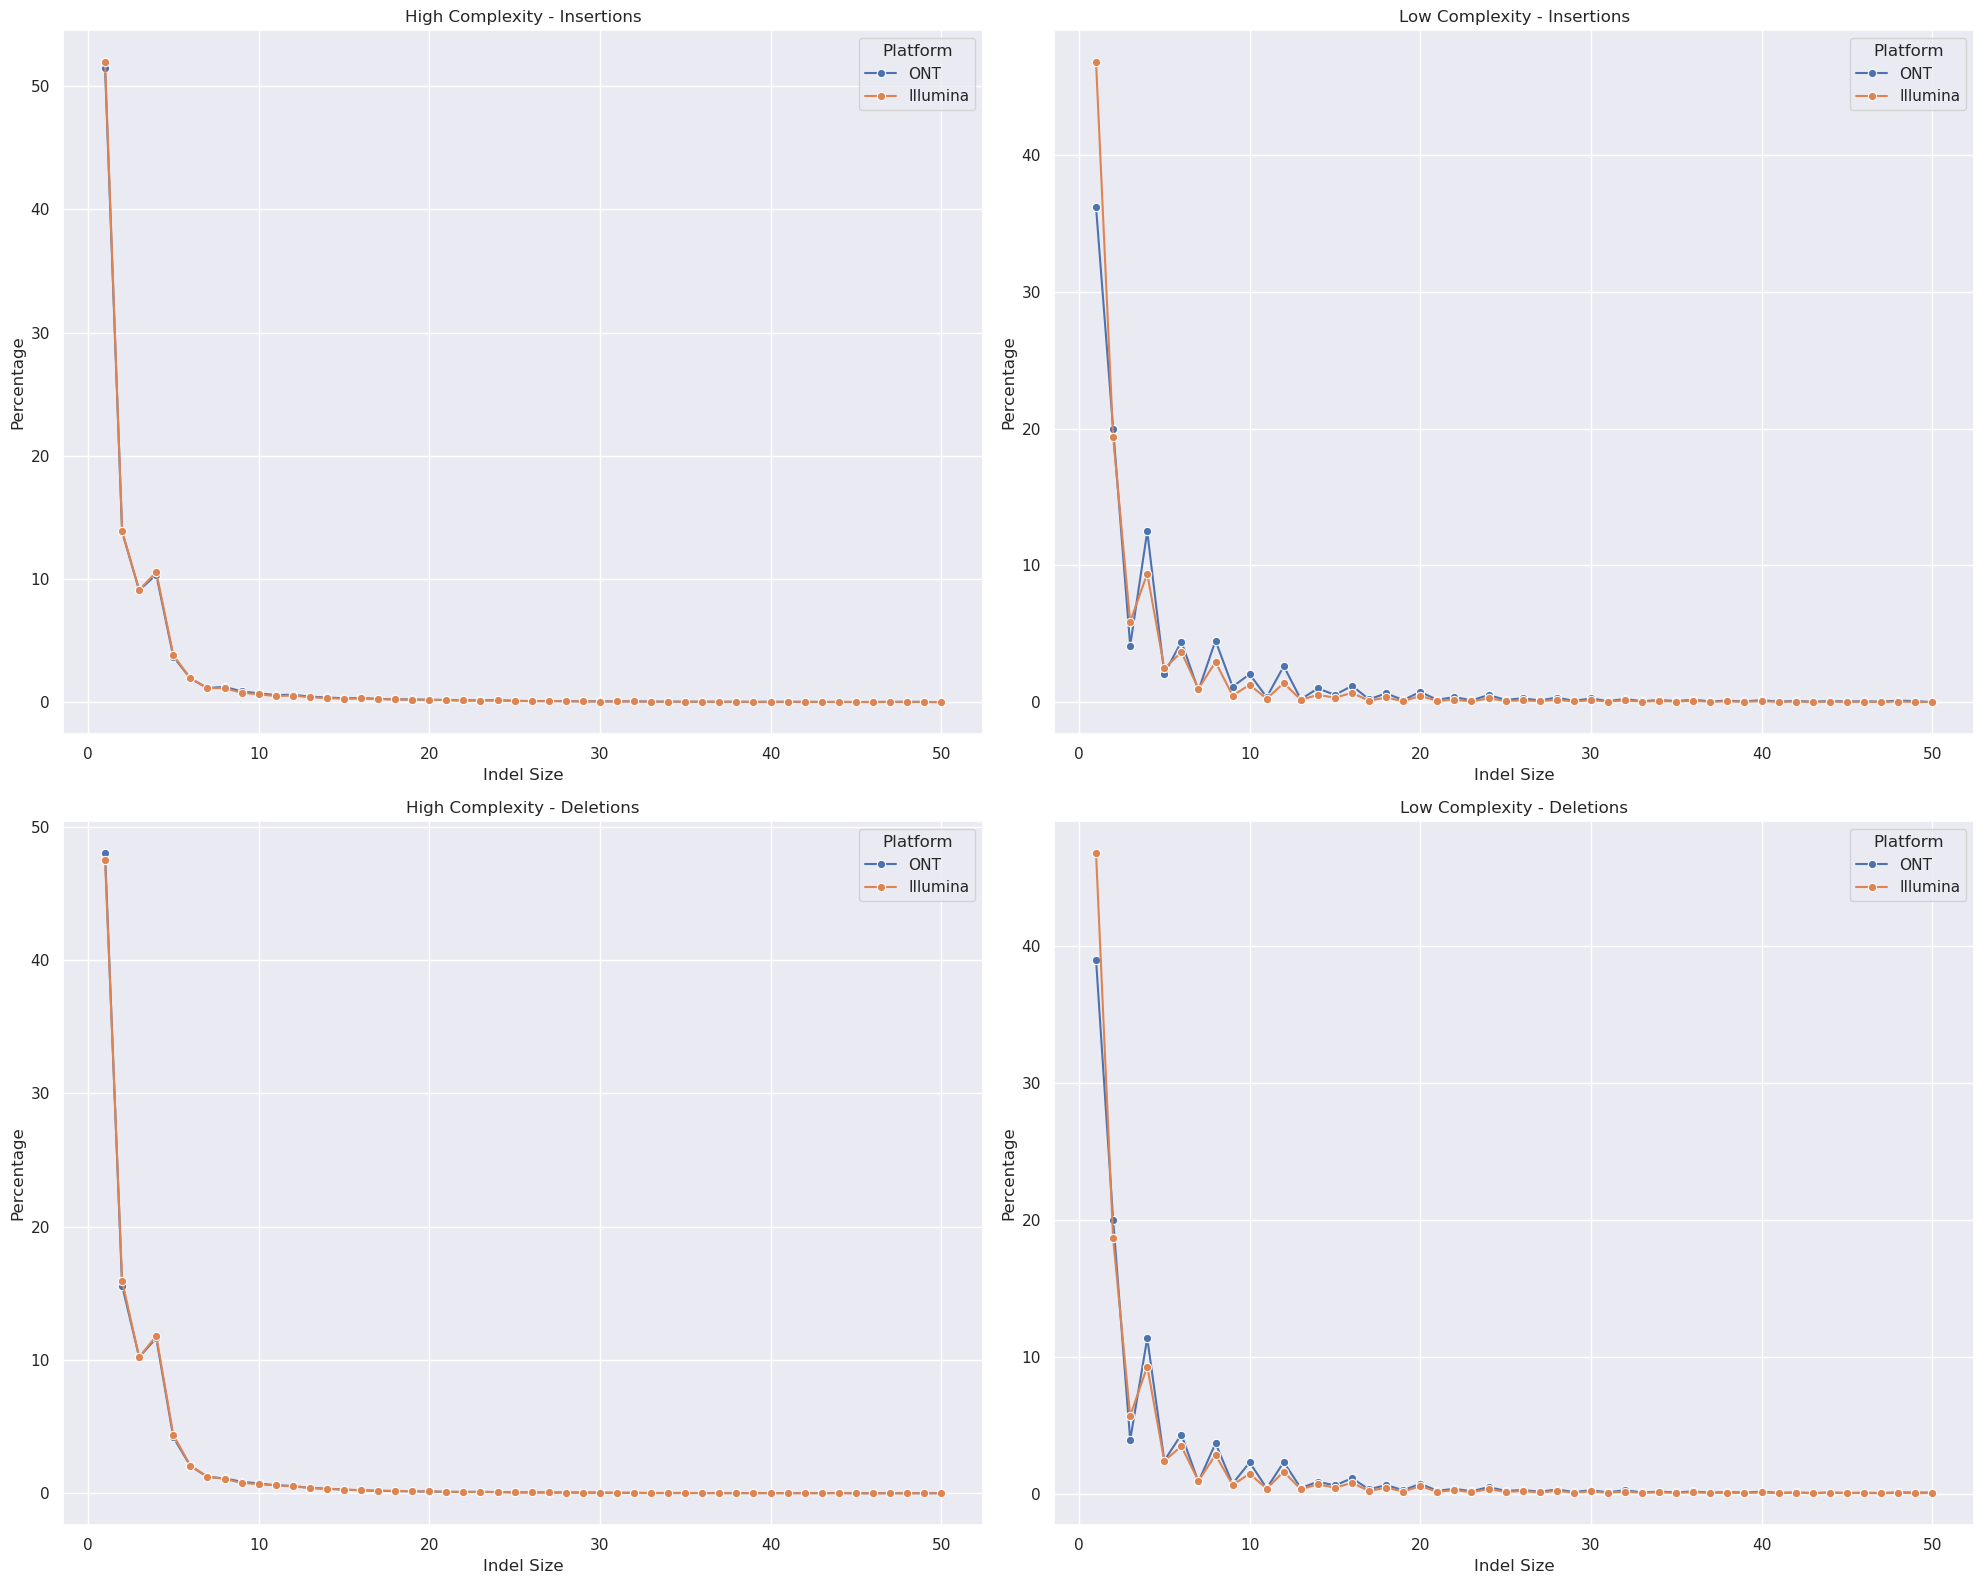

In [14]:
def analyze_indel_size_distribution(complexity, sample_ids):
    ont_sizes = defaultdict(lambda: defaultdict(int))
    illumina_sizes = defaultdict(lambda: defaultdict(int))

    for _, row in sample_ids.iterrows():
        sample_id = row["ont_id"]
        base_path = f"output/indel/rtg_vcfeval/{complexity}/{sample_id}.indel"

        query_file = os.path.join(base_path, "query.vcf.gz")
        truth_file = os.path.join(base_path, "truth.vcf.gz")

        with pysam.VariantFile(query_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                ont_sizes[indel_type][indel_length] += 1

        with pysam.VariantFile(truth_file) as vcf:
            for record in vcf:
                indel_type = (
                    "insertion" if len(record.alts[0]) > len(record.ref) else "deletion"
                )
                indel_length = abs(len(record.alts[0]) - len(record.ref))
                illumina_sizes[indel_type][indel_length] += 1

    return ont_sizes, illumina_sizes


def prepare_plot_data(ont_sizes, illumina_sizes, complexity):
    plot_data = []
    for indel_type in ["insertion", "deletion"]:
        ont_total = sum(ont_sizes[indel_type].values())
        illumina_total = sum(illumina_sizes[indel_type].values())
        max_size = max(
            max(ont_sizes[indel_type].keys()), max(illumina_sizes[indel_type].keys())
        )

        for size in range(1, max_size + 1):
            ont_percent = (
                (ont_sizes[indel_type][size] / ont_total) * 100 if ont_total > 0 else 0
            )
            illumina_percent = (
                (illumina_sizes[indel_type][size] / illumina_total) * 100
                if illumina_total > 0
                else 0
            )

            plot_data.append(
                {
                    "Indel Type": indel_type,
                    "Size": size,
                    "Percentage": ont_percent,
                    "Platform": "ONT",
                    "Complexity": complexity,
                }
            )
            plot_data.append(
                {
                    "Indel Type": indel_type,
                    "Size": size,
                    "Percentage": illumina_percent,
                    "Platform": "Illumina",
                    "Complexity": complexity,
                }
            )
    return plot_data


hc_ont_sizes, hc_illumina_sizes = analyze_indel_size_distribution("hc", sample_ids)
lc_ont_sizes, lc_illumina_sizes = analyze_indel_size_distribution("lc", sample_ids)

hc_plot_data = prepare_plot_data(hc_ont_sizes, hc_illumina_sizes, "High Complexity")
lc_plot_data = prepare_plot_data(lc_ont_sizes, lc_illumina_sizes, "Low Complexity")

plot_data = pd.DataFrame(hc_plot_data + lc_plot_data)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
indel_types = ["insertion", "deletion"]
complexities = ["High Complexity", "Low Complexity"]

for i, indel_type in enumerate(indel_types):
    for j, complexity in enumerate(complexities):
        data = plot_data[
            (plot_data["Indel Type"] == indel_type)
            & (plot_data["Complexity"] == complexity)
        ]

        sns.lineplot(
            data=data,
            x="Size",
            y="Percentage",
            hue="Platform",
            ax=axes[i, j],
            marker="o",
        )

        axes[i, j].set_title(f"{complexity} - {indel_type.capitalize()}s")
        axes[i, j].set_xlabel("Indel Size")
        axes[i, j].set_ylabel("Percentage")
        axes[i, j].legend(title="Platform")

plt.tight_layout()
plt.show()


In [15]:
def calculate_summary_stats(sizes):
    total = sum(sizes.values())
    if total == 0:
        return {"total": 0, "mean": 0, "median": 0, "std": 0}

    sizes_array = np.array([(k, v) for k, v in sizes.items()])
    mean = np.average(sizes_array[:, 0], weights=sizes_array[:, 1])
    median = np.median(np.repeat(sizes_array[:, 0], sizes_array[:, 1].astype(int)))
    std = np.sqrt(
        np.average((sizes_array[:, 0] - mean) ** 2, weights=sizes_array[:, 1])
    )

    return {"total": total, "mean": mean, "median": median, "std": std}


print("\nSummary Statistics:")
for complexity, (ont_sizes, illumina_sizes) in [
    ("High Complexity", (hc_ont_sizes, hc_illumina_sizes)),
    ("Low Complexity", (lc_ont_sizes, lc_illumina_sizes)),
]:
    print(f"\n{complexity}")
    for indel_type in ["insertion", "deletion"]:
        ont_stats = calculate_summary_stats(ont_sizes[indel_type])
        illumina_stats = calculate_summary_stats(illumina_sizes[indel_type])

        print(f"  {indel_type.capitalize()}s:")
        print(
            f"    ONT     - Total: {ont_stats['total']}, Mean Size: {ont_stats['mean']:.2f}, Std Dev: {ont_stats['std']:.2f}, Median Size: {ont_stats['median']}"
        )
        print(
            f"    Illumina - Total: {illumina_stats['total']}, Mean Size: {illumina_stats['mean']:.2f}, Std Dev: {illumina_stats['std']:.2f}, Median Size: {illumina_stats['median']}"
        )



Summary Statistics:

High Complexity
  Insertions:
    ONT     - Total: 346667, Mean Size: 3.22, Std Dev: 4.90, Median Size: 1.0
    Illumina - Total: 341865, Mean Size: 3.10, Std Dev: 4.68, Median Size: 1.0
  Deletions:
    ONT     - Total: 350694, Mean Size: 3.02, Std Dev: 4.12, Median Size: 2.0
    Illumina - Total: 338630, Mean Size: 3.01, Std Dev: 4.05, Median Size: 2.0

Low Complexity
  Insertions:
    ONT     - Total: 711864, Mean Size: 4.98, Std Dev: 7.01, Median Size: 2.0
    Illumina - Total: 1120916, Mean Size: 3.60, Std Dev: 5.48, Median Size: 2.0
  Deletions:
    ONT     - Total: 807358, Mean Size: 4.74, Std Dev: 6.83, Median Size: 2.0
    Illumina - Total: 1106928, Mean Size: 3.78, Std Dev: 5.70, Median Size: 2.0


In [16]:
def compare_distributions(ont_sizes, illumina_sizes):
    ont_dist = [size for size, count in ont_sizes.items() for _ in range(count)]
    illumina_dist = [
        size for size, count in illumina_sizes.items() for _ in range(count)
    ]

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = stats.ks_2samp(ont_dist, illumina_dist)

    return ks_statistic, p_value


all_p_values = []
test_results = []

for complexity, (ont_sizes, illumina_sizes) in [
    ("High Complexity", (hc_ont_sizes, hc_illumina_sizes)),
    ("Low Complexity", (lc_ont_sizes, lc_illumina_sizes)),
]:
    for indel_type in ["insertion", "deletion"]:
        ks_statistic, p_value = compare_distributions(
            ont_sizes[indel_type], illumina_sizes[indel_type]
        )
        all_p_values.append(p_value)
        test_results.append((complexity, indel_type, ks_statistic, p_value))

# Perform FDR correction
_, corrected_p_values, _, _ = multipletests(all_p_values, method="fdr_bh")

print("\nStatistical Test Results (Kolmogorov-Smirnov test with FDR correction):")
for (complexity, indel_type, ks_statistic, p_value), corrected_p_value in zip(
    test_results, corrected_p_values
):
    print(f"\n{complexity} - {indel_type.capitalize()}s:")
    print(f"    KS statistic: {ks_statistic:.4f}")
    print(f"    Original p-value: {p_value:.4e}")
    print(f"    Corrected p-value: {corrected_p_value:.4e}")



Statistical Test Results (Kolmogorov-Smirnov test with FDR correction):

High Complexity - Insertions:
    KS statistic: 0.0088
    Original p-value: 5.6680e-12
    Corrected p-value: 7.5574e-12

High Complexity - Deletions:
    KS statistic: 0.0048
    Original p-value: 7.5297e-04
    Corrected p-value: 7.5297e-04

Low Complexity - Insertions:
    KS statistic: 0.1173
    Original p-value: 0.0000e+00
    Corrected p-value: 0.0000e+00

Low Complexity - Deletions:
    KS statistic: 0.0818
    Original p-value: 0.0000e+00
    Corrected p-value: 0.0000e+00


# SV Benchmark

## SV Consensus Calls


In [17]:
def read_vcf(file_path):
    svs = []
    with pysam.VariantFile(file_path) as vcf:
        for record in vcf:
            sv_type = record.info.get("SVTYPE", "Unknown")
            if sv_type == "BND":
                sv_type = "TRA"  # Classify breakends as translocations
            sv_length = record.info.get("SVLEN", 0)
            if isinstance(sv_length, tuple):
                sv_length = abs(sv_length[0]) if sv_length else 0
            else:
                sv_length = abs(sv_length)
            if sv_length == 0 and record.info.get("END"):
                sv_length = record.info["END"] - record.pos
            chrom = record.chrom
            start = record.start
            end = record.stop if record.stop else start + sv_length
            svs.append(
                {
                    "type": sv_type,
                    "length": sv_length,
                    "chrom": chrom,
                    "start": start,
                    "end": end,
                }
            )
    return pd.DataFrame(svs)


def analyze_sv_calls(sample_id, ont_id, illumina_id):
    ont_file = f"output/sv/survivor/{ont_id}/{ont_id}.ont.sv.filtered.vcf"
    illumina_file = (
        f"output/sv/survivor/{ont_id}/{illumina_id}.illumina.sv.filtered.vcf"
    )
    merged_file = f"output/sv/survivor/{ont_id}/{ont_id}_{illumina_id}_merged.vcf"

    ont_svs = read_vcf(ont_file)
    illumina_svs = read_vcf(illumina_file)
    merged_svs = read_vcf(merged_file)

    return {
        "sample_id": sample_id,
        "ont": ont_svs,
        "illumina": illumina_svs,
        "merged": merged_svs,
    }


def compare_sv_counts(sv_data):
    counts = []
    for sample_id, data in sv_data.items():
        counts.append(
            {
                "Sample": sample_id,
                "ONT": len(data["ont"]),
                "Illumina": len(data["illumina"]),
                "Merged": len(data["merged"]),
            }
        )
    return pd.DataFrame(counts)


sv_data = {}
for _, row in sample_ids.iterrows():
    sample_data = analyze_sv_calls(row["ont_id"], row["ont_id"], row["lp_id"])
    sv_data[row["ont_id"]] = sample_data

sv_counts = compare_sv_counts(sv_data)
print("SV call counts:")
sv_counts


SV call counts:


,Sample,ONT,Illumina,Merged
0,A149_01,27537,9245,5274
1,A153_01,29625,9542,5678
2,A153_06,33899,9266,5951


<Figure size 2000x1000 with 0 Axes>

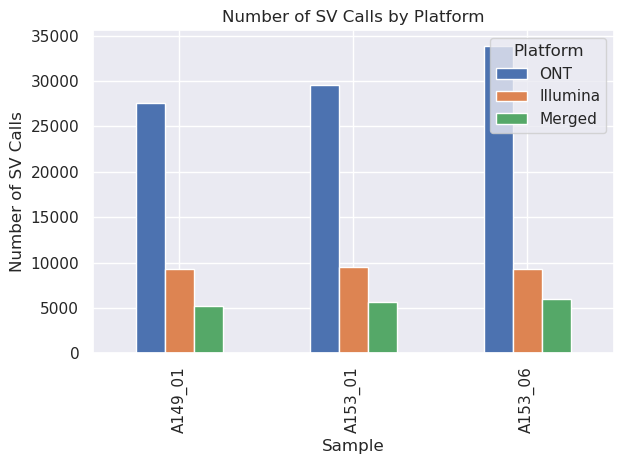

In [18]:
plt.figure(figsize=(20, 10))
sv_counts.set_index("Sample").plot(kind="bar")
plt.title("Number of SV Calls by Platform")
plt.ylabel("Number of SV Calls")
plt.legend(title="Platform")
plt.tight_layout()
plt.show()


## SV Types


In [19]:
def analyze_sv_types(sv_data):
    type_counts = defaultdict(lambda: defaultdict(int))
    for sample_id, data in sv_data.items():
        for platform in ["ont", "illumina"]:
            for sv_type, count in data[platform]["type"].value_counts().items():
                type_counts[(sample_id, platform)][sv_type] = count
    return pd.DataFrame(type_counts).T


sv_types = analyze_sv_types(sv_data)
print("\nSV type counts:")
sv_types



SV type counts:


INS      DEL    TRA   INV   DUP
A149_01 ont       15127.0  12328.0   49.0  21.0  12.0
        illumina   3103.0   5441.0  700.0   1.0   NaN
A153_01 ont       16163.0  13376.0   56.0  21.0   9.0
        illumina   3249.0   5486.0  806.0   1.0   NaN
A153_06 ont       18690.0  15064.0   95.0  33.0  17.0
        illumina   3115.0   5443.0  707.0   1.0   NaN

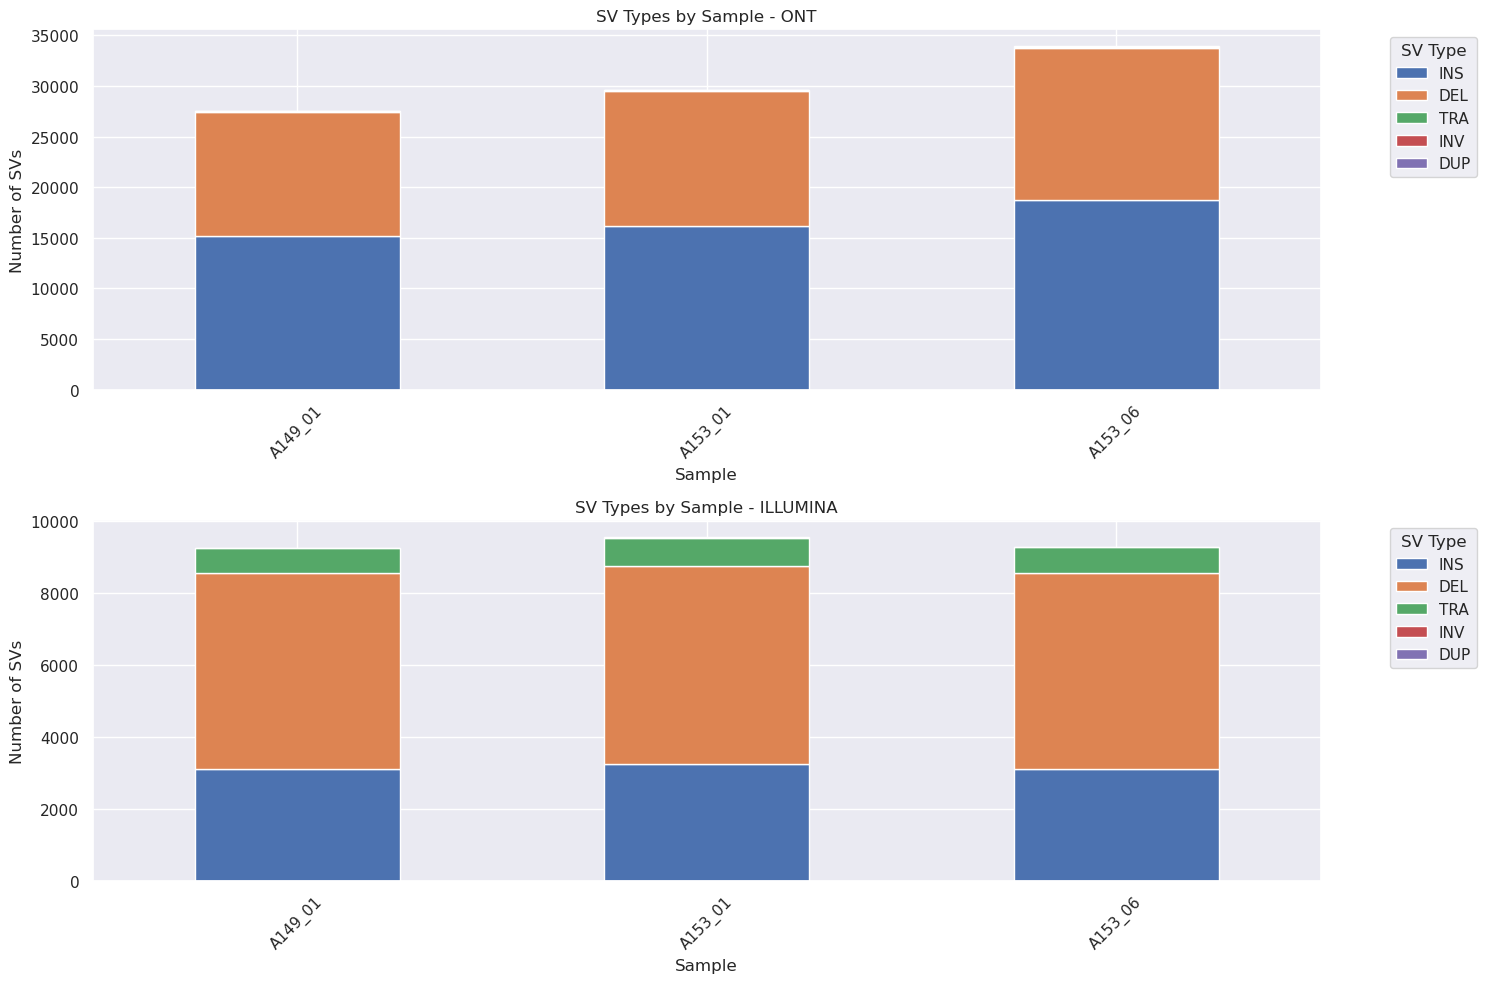

In [20]:
plt.figure(figsize=(15, 10))
for i, platform in enumerate(["ont", "illumina"]):
    plt.subplot(2, 1, i + 1)
    sv_types.xs(platform, level=1).plot(kind="bar", stacked=True, ax=plt.gca())
    plt.title(f"SV Types by Sample - {platform.upper()}")
    plt.xlabel("Sample")
    plt.ylabel("Number of SVs")
    plt.legend(title="SV Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## SV Size Distribution


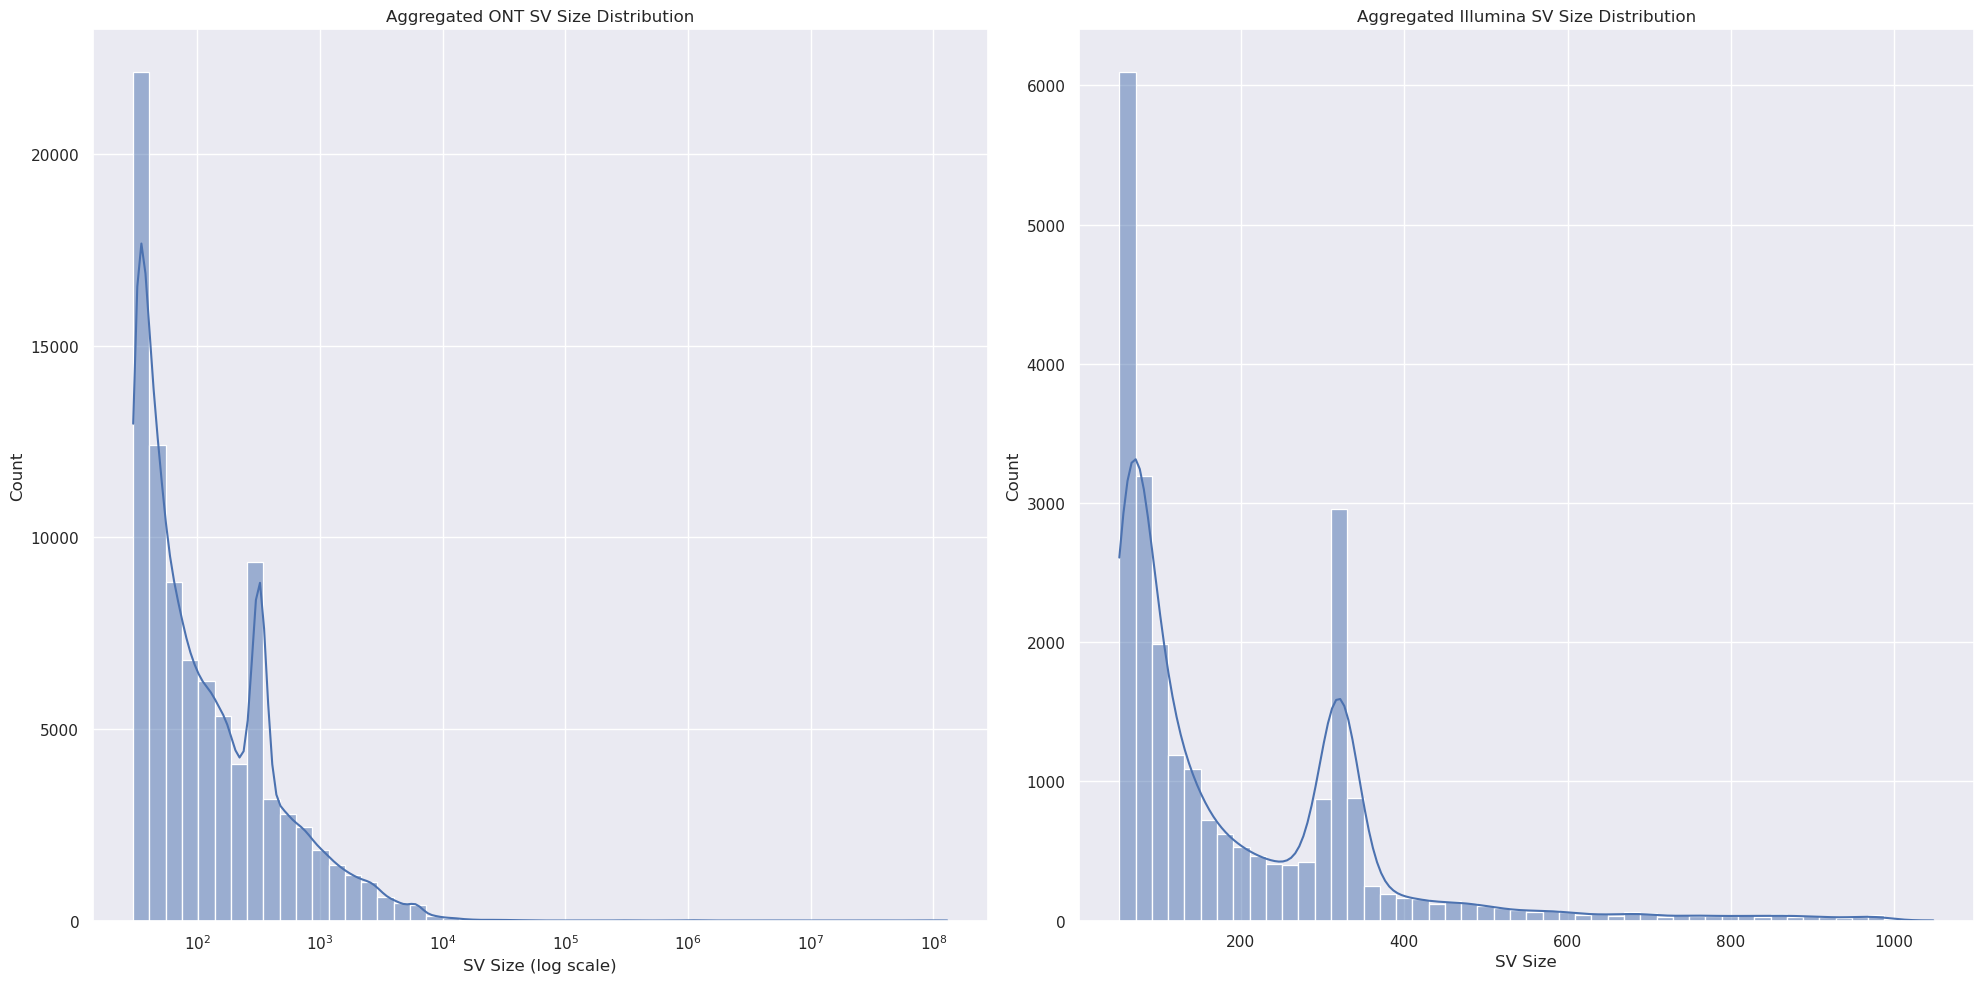

In [21]:
ont_lengths = []
illumina_lengths = []

for data in sv_data.values():
    ont_lengths.extend(data["ont"]["length"][data["ont"]["length"] > 0])
    illumina_lengths.extend(data["illumina"]["length"][data["illumina"]["length"] > 0])

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(ont_lengths, kde=True, log_scale=True, bins=50)
plt.title("Aggregated ONT SV Size Distribution")
plt.xlabel("SV Size (log scale)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(illumina_lengths, bins=50, kde=True)
plt.title("Aggregated Illumina SV Size Distribution")
plt.xlabel("SV Size")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [22]:
print("\nSummary statistics for SVs:")
for platform, lengths in [("ONT", ont_lengths), ("ILLUMINA", illumina_lengths)]:
    print(f"  {platform}:")
    print(f"    Count: {len(lengths)}")
    print(f"    Mean: {np.mean(lengths):.2f}")
    print(f"    Median: {np.median(lengths):.2f}")
    print(f"    Min: {np.min(lengths)}")
    print(f"    Max: {np.max(lengths)}")
    print(f"    25th percentile: {np.percentile(lengths, 25):.2f}")
    print(f"    75th percentile: {np.percentile(lengths, 75):.2f}")



Summary statistics for SVs:
  ONT:
    Count: 90861
    Mean: 6012.17
    Median: 82.00
    Min: 30
    Max: 129371498
    25th percentile: 41.00
    75th percentile: 300.00
  ILLUMINA:
    Count: 24122
    Mean: 191.96
    Median: 123.00
    Min: 51
    Max: 1048
    25th percentile: 70.00
    75th percentile: 311.00


## SV Chromosomal Distribution


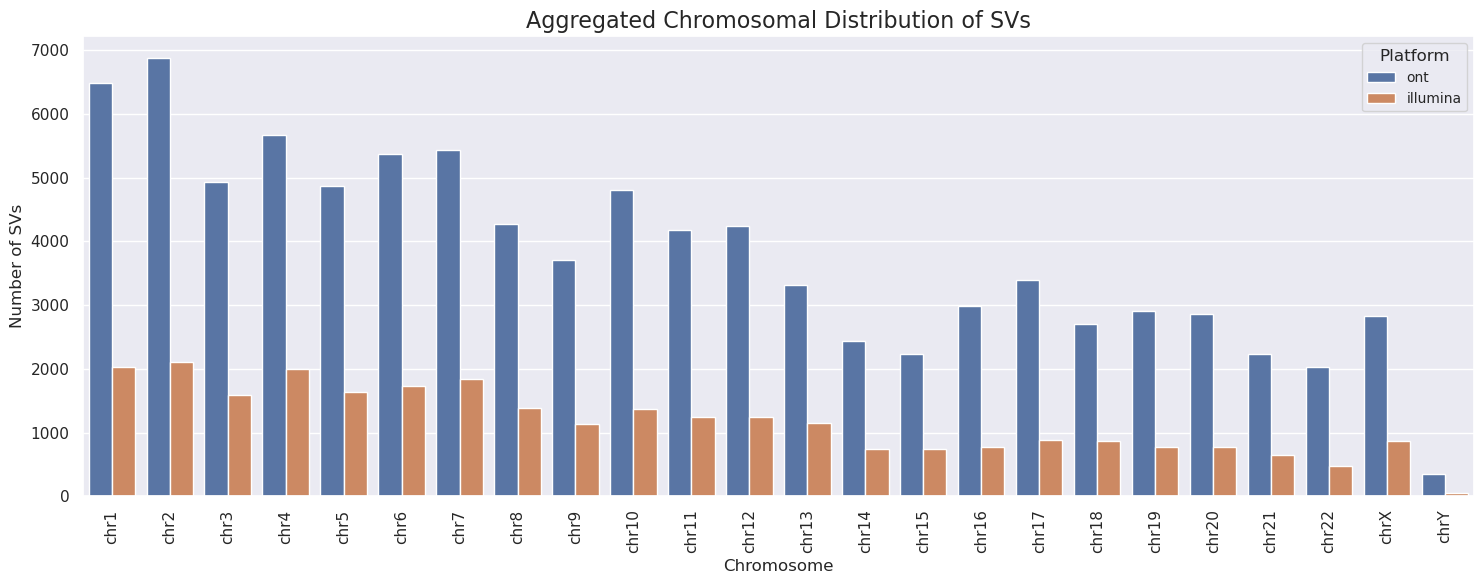

In [23]:
def analyze_chrom_distribution(sv_data):
    valid_chroms = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
    chrom_counts = defaultdict(lambda: defaultdict(int))
    for sample_id, data in sv_data.items():
        for platform in ["ont", "illumina"]:
            for chrom in valid_chroms:
                chrom_counts[platform][chrom] += data[platform][
                    data[platform]["chrom"] == chrom
                ].shape[0]
    return pd.DataFrame(chrom_counts)


chrom_distribution = analyze_chrom_distribution(sv_data)

chrom_distribution_melted = chrom_distribution.reset_index().melt(
    id_vars="index", var_name="Platform", value_name="Count"
)
chrom_distribution_melted = chrom_distribution_melted.rename(
    columns={"index": "Chromosome"}
)

plt.figure(figsize=(15, 6))
ax = sns.barplot(
    x="Chromosome", y="Count", hue="Platform", data=chrom_distribution_melted
)

plt.title("Aggregated Chromosomal Distribution of SVs", fontsize=16)
plt.xlabel("Chromosome", fontsize=12)
plt.ylabel("Number of SVs", fontsize=12)
plt.legend(title="Platform", title_fontsize=12, fontsize=10)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
